In [37]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

import seaborn as sns

import itertools

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# from deslib.static.stacked import StackedClassifier

from vecstack import stacking

import warnings
warnings.filterwarnings('ignore')


# DATA PREP

In [38]:
raw_df = pd.read_csv('online_shoppers_intention.csv')

In [39]:
raw_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [40]:
raw_df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

Things to look at:
* SMOTE
* Bagging, boosting and stacking and Voting
* Logistic regression
* Decision Tree
* Random Forest
* SVM
* PCA
* Clustering


In [41]:
raw_df['VisitorType'].value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [42]:
# removing the 'Other' category from 'VisitorType'
df = raw_df.set_index('VisitorType')
df = df.drop(['Other'], axis=0)
df = df.reset_index()
print(df['VisitorType'].value_counts())

df_vt = pd.get_dummies(df['VisitorType'])
df = df.merge(df_vt, left_index = True, right_index=True)

df_w = pd.get_dummies(df['Weekend'])
df = df.merge(df_w, left_index = True, right_index=True)

df_r = pd.get_dummies(df['Revenue'])
df = df.merge(df_r, left_index = True, right_index=True)

df = df.drop(['VisitorType', 'Returning_Visitor', 'Weekend', 'Revenue', 'False_x', 'False_y'], axis=1)
df = df.rename(columns={"True_x": "Weekend", "True_y": "Revenue"})

month = {'Feb':2, 'Mar':3, 'May':5, 'Oct':10, 
         'June':6, 'Jul':7, 'Aug':8, 'Nov':11, 
         'Sep':9, 'Dec':12}
df.Month = [month[item] for item in df.Month]

Returning_Visitor    10551
New_Visitor           1694
Name: VisitorType, dtype: int64


In [43]:
df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,New_Visitor,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12240,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,0,1,0
12241,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,0,1,0
12242,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,0,1,0
12243,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,0,0,0


In [44]:
y = df['Revenue']
X = df[['Administrative','Administrative_Duration',
        'Informational', 'Informational_Duration', 
        'ProductRelated', 'ProductRelated_Duration', 
        'BounceRates', 'ExitRates','PageValues',
        'SpecialDay','Month','OperatingSystems','Browser',
        'Region', 'TrafficType', 'Weekend']]


In [45]:
# SMOTE - to correct for imbalanced class
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_resampled, y_resampled = smote.fit_sample(X, y) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    10353
1     1892
Name: Revenue, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    10353
0    10353
Name: Revenue, dtype: int64


In [46]:
X_resampled

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend
0,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,0
1,0,0.000000,0,0.000000,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,0
2,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,0
3,0,0.000000,0,0.000000,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,0
4,0,0.000000,0,0.000000,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20701,2,85.683233,0,0.000000,22,457.298072,0.001832,0.016795,19.860261,0.0,3,1,2,2,2,0
20702,0,0.000000,0,0.000000,22,1296.814924,0.000000,0.007063,67.413304,0.0,5,2,2,1,2,0
20703,0,0.000000,0,0.000000,6,227.676316,0.015532,0.058543,29.410939,0.0,7,2,2,1,1,0
20704,3,142.589068,1,16.800614,22,739.857313,0.000000,0.020015,18.674223,0.0,6,2,4,3,5,0


# MODELLING

In [47]:
skf = StratifiedKFold(n_splits=5)

In [75]:
class Classification():
    
    def __init__(self, model, x_train, x_val, y_train, y_val):
        self.model = model
        self.x_train = x_train
        self.x_val = x_val
        self.y_train = y_train
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        
        if self.model == 'Decision Tree':
            self.fitting = DecisionTreeClassifier(random_state = 42)
        elif self.model == 'Random Forest':
            self.fitting = RandomForestClassifier(n_estimators = 10, 
                                                    n_jobs = -1, random_state=42)
        elif self.model == 'Logistic Regression':
            self.fitting = LogisticRegression(fit_intercept = True)
#         elif SVM
#         elif Naive Bayes

            
    def scores(self,model,X_train,X_val,y_train,y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]

        auc_train = roc_auc_score(y_train,train_prob)
        auc_val = roc_auc_score(y_val,val_prob)

        self.auc_train = auc_train
        self.auc_val = auc_val

        self.scores_table["Model Name"] = [self.model]
        self.scores_table["Train AUC"] = [self.auc_train]
        self.scores_table["Validation AUC"] = [self.auc_val]

        return self.scores_table


    def annot(fpr,tpr,thr):
        k=0
        for i,j in zip(fpr,tpr):
            if k %50 == 0:
                plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
            k+=1
    
    
    def roc_plot(model,X_train,X_val,y_train,y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        plt.figure(figsize=(7,7))
        for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
            fpr, tpr, threshold = roc_curve(data[0], data[1])
            plt.plot(fpr, tpr)
        Classification.annot(fpr, tpr, threshold)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('TPR (power)')
        plt.xlabel('FPR (alpha)')
        plt.legend(['train','val'])
        plt.show()
        

    def get_scores(self,param_grid,cv_type):
        reg = self.fitting
        fit_reg = reg.fit(self.x_train,self.y_train)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.x_train,self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Classification.scores(self,self.best_model,
                                            self.x_train,self.x_val,
                                            self.y_train,self.y_val)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        print("The best hyperparameters are: ", self.best_params,'\n')
        self.roc_plot = Classification.roc_plot(self.best_model,
                                                self.x_train,self.x_val,
                                                self.y_train,self.y_val)
        self.y_tested = opt_model.predict(self.x_val)
        
        
    def opt_plots(self):
        if self.model == "Decision Tree" or self.model == "Random Forest":
            opt = pd.DataFrame(self.opt_model.cv_results_)
            cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
            params = pd.DataFrame(list(opt.params))
            opt = pd.concat([params,opt[cols]],axis=1,sort=False)

            plt.figure(figsize=[15,4])
            plt.subplot(121)
            sns.heatmap(pd.pivot_table(opt,index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_train_score')*100)
            plt.title('ROC_AUC - Training')
            plt.subplot(122)
            sns.heatmap(pd.pivot_table(opt,index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_test_score')*100)
            plt.title('ROC_AUC - Validation')
        else:
            print("This model does not have an optimum hyperparameter plot!")
            
            
    def conf_matrix(y_true, y_pred):
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}

        for ind, label in enumerate(y_true):
            pred = y_pred[ind]
            if label == 1: 
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1

        return cm
    
    
    def show_conf_matrix(self):
        Classification.conf_matrix(self.y_val, self.y_tested)
        cnf_matrix = confusion_matrix(self.y_val, self.y_tested)

        plt.figure(figsize=(7,7))
        plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)

        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        class_names = set(y)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar
        
        
    def plot_decision_tree(self):
        if self.model == "Decision Tree":
            plt.figure(figsize=(22,22))
            tree.plot_tree(self.best_model.fit(self.x_train,self.y_train))
        else:
            print("This model does not have a decision tree plot!")
            
            
    def threshold_selection(self, prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y_train, y_test):
        fpr, tpr, thresholds = roc_curve(self.y_train, self.y_test)
        m = ((1 - prevalence) / prevalence) * ((CostFP_minus_CostTN) / (CostFN_minus_CostTP))
        fm_thresholds = []
        for i in range(len(fpr)):
            fm = tpr[i] - (m * fpr[i])
            fm_thresholds.append((thresholds[i], fm))
        fm_thresholds = sorted(fm_thresholds, key=lambda fm_value: fm_value[1], reverse=True)
        return fm_thresholds[0][0]




In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.25, random_state=42)

X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42)


## Logistic Regression

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.913629,0.91898


The best hyperparameters are:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} 



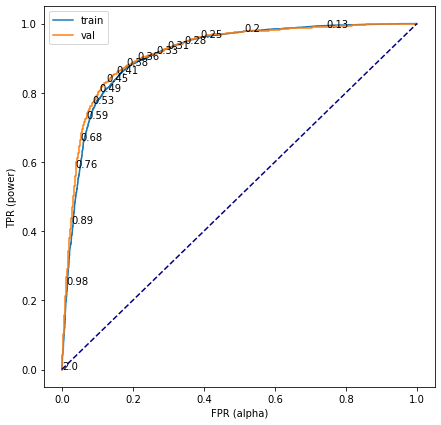

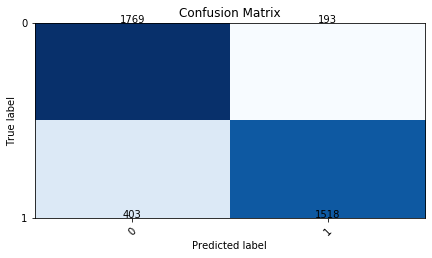

In [84]:
logistic = Classification('Logistic Regression', X_train_v, X_val, y_train_v, y_val)

param_grid = {"penalty":['l1', 'l2', 'elasticnet', 'none'],            # l1 and l2 are different type of penalties
              "solver" : ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
              "C":[0.5, 1, 5]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization
# param_grid = {}

logistic.get_scores(param_grid,skf)
logistic.show_conf_matrix()

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.913629,0.91898


The best hyperparameters are:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} 



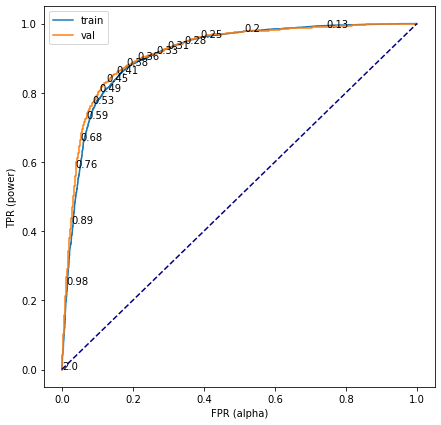

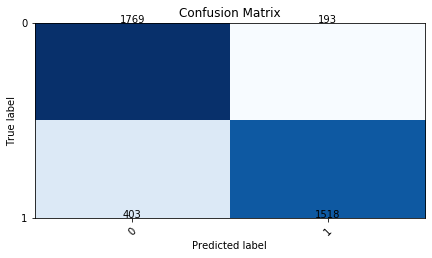

In [85]:
logistic = Classification('Logistic Regression', X_train_v, X_val, y_train_v, y_val)

param_grid = {"penalty":['l2'],            # l1 and l2 are different type of penalties
              "solver" : ['liblinear'],  # Algorithm to use in the optimization problem
              "C":[0.7, 0.8, 0.9, 1, 1.1, 1.2]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization
# param_grid = {}

logistic.get_scores(param_grid,skf)
logistic.show_conf_matrix()

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.911799,0.917725


The best hyperparameters are:  {'C': 0.8, 'penalty': 'l2', 'solver': 'liblinear'} 



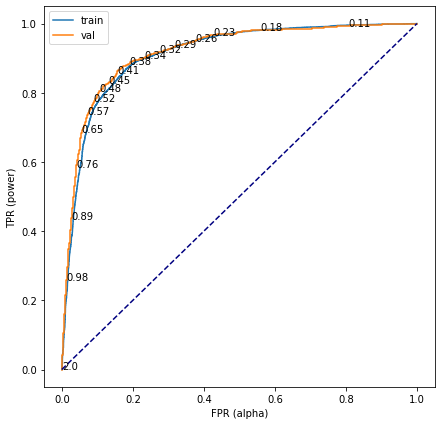

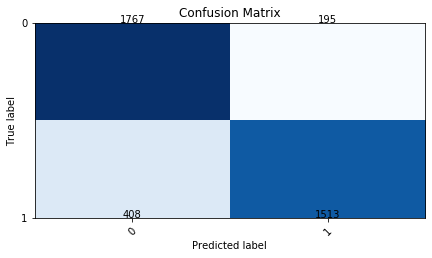

In [86]:
logistic = Classification('Logistic Regression', X_train_v, X_val, y_train_v, y_val)

param_grid = {"penalty":['l2'],            # l1 and l2 are different type of penalties
              "solver" : ['liblinear'],  # Algorithm to use in the optimization problem
              "C":[0.75, 0.775, 0.8, 0.825, 0.85]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization
# param_grid = {}

logistic.get_scores(param_grid,skf)
logistic.show_conf_matrix()

## Decision Tree

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.963658,0.958625


The best hyperparameters are:  {'max_depth': 9, 'min_samples_leaf': 100} 



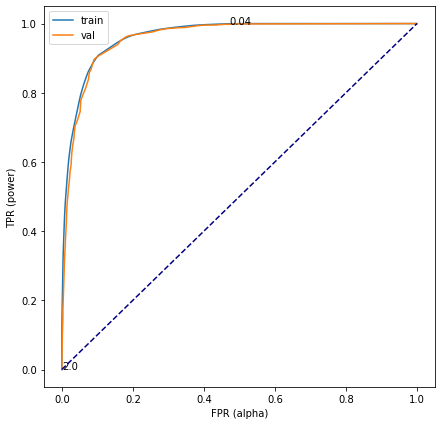

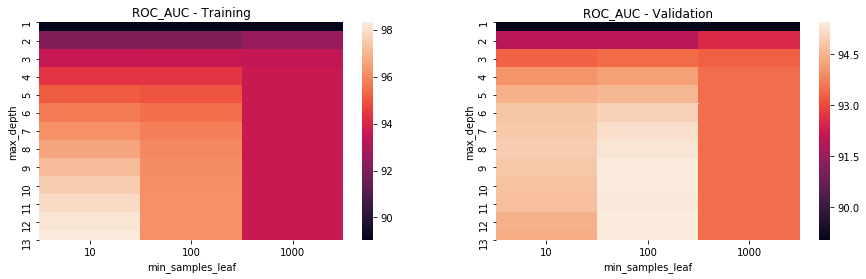

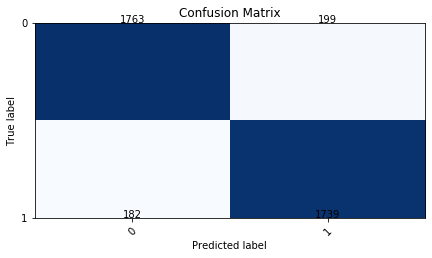

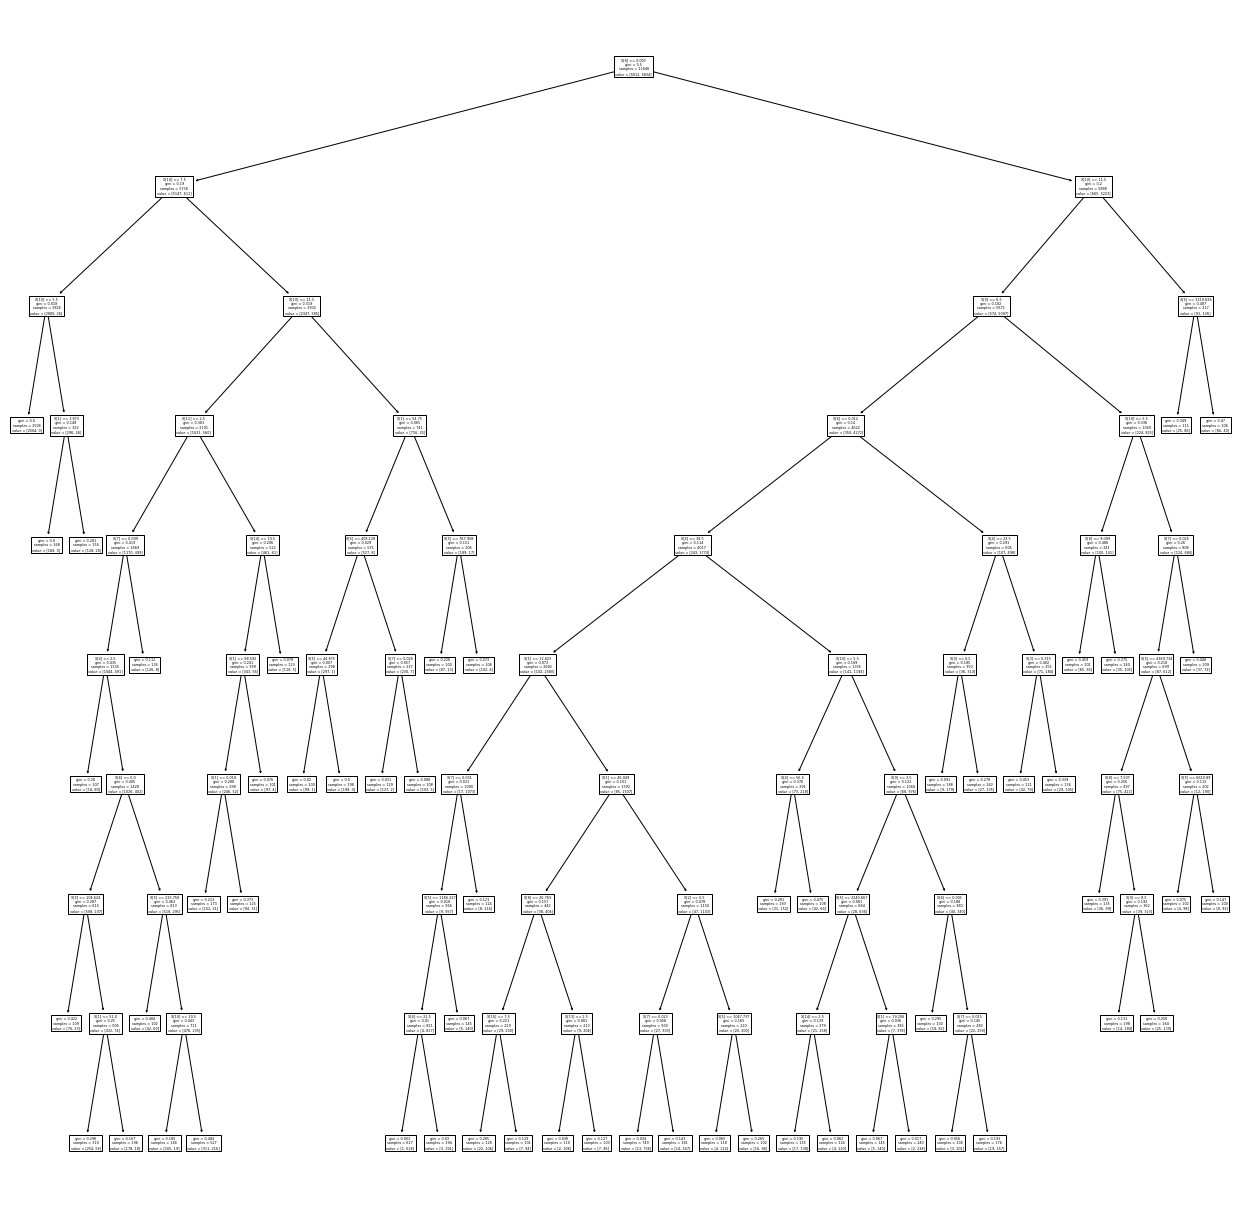

In [79]:
dtree = Classification('Decision Tree', X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],                 # The maximum depth of the tree
              'min_samples_leaf':[10, 100, 1000]}  # The minimum number of samples required to be at a leaf node

dtree.get_scores(param_grid,skf)
dtree.opt_plots()
dtree.show_conf_matrix()
dtree.plot_decision_tree()

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.966006,0.958603


The best hyperparameters are:  {'max_depth': 10, 'min_samples_leaf': 75} 



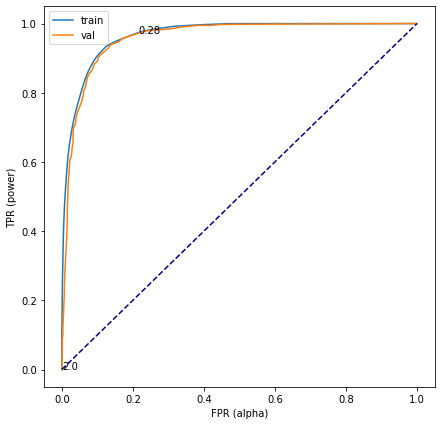

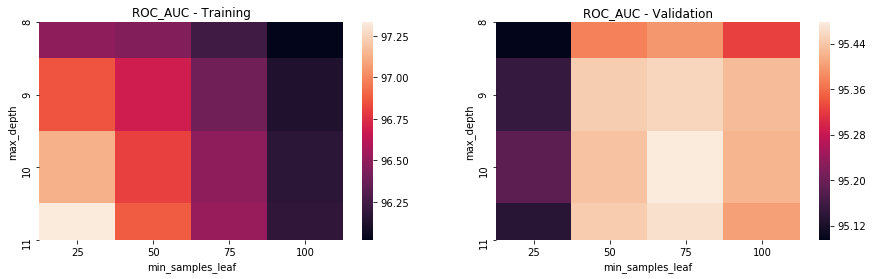

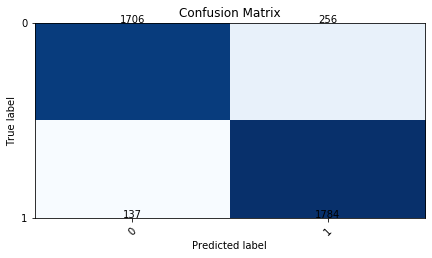

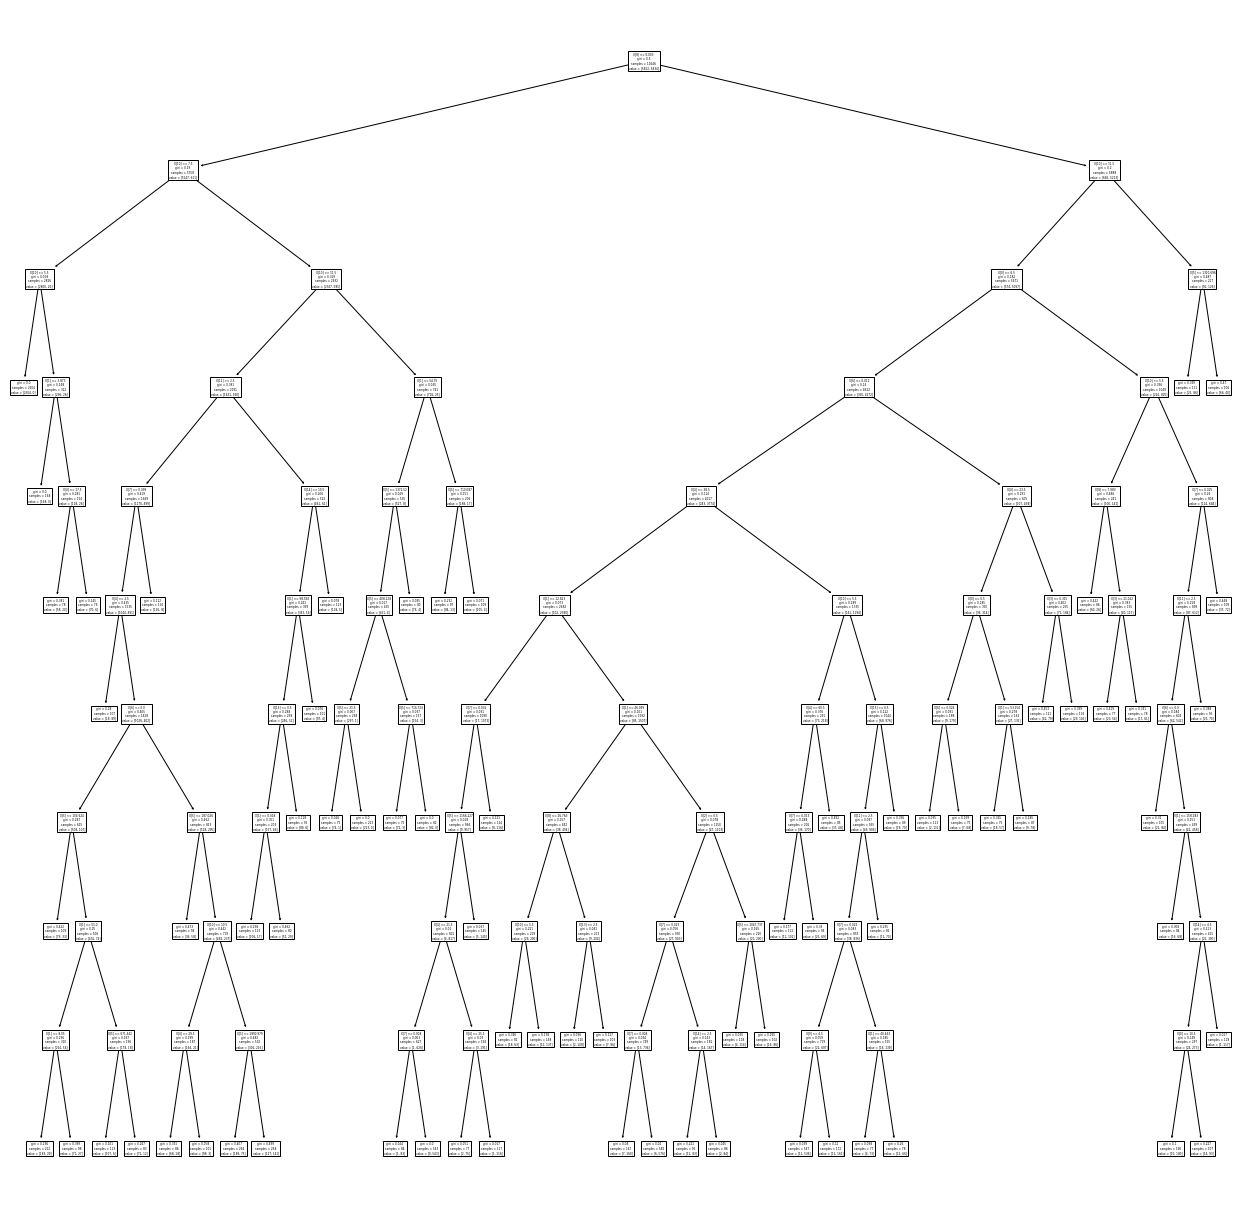

In [81]:
dtree = Classification('Decision Tree', X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[8, 9, 10, 11],                 # The maximum depth of the tree
              'min_samples_leaf':[25, 50, 75, 100]}  # The minimum number of samples required to be at a leaf node

dtree.get_scores(param_grid,skf)
dtree.opt_plots()
dtree.show_conf_matrix()
dtree.plot_decision_tree()

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.96578,0.958648


The best hyperparameters are:  {'max_depth': 10, 'min_samples_leaf': 80} 



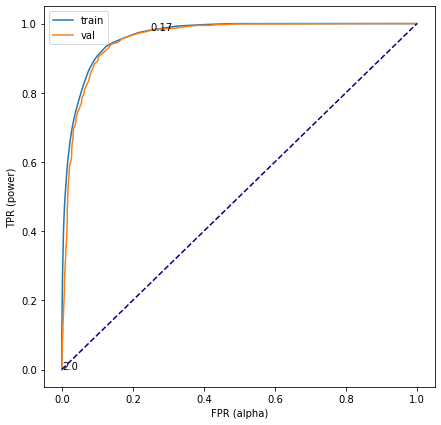

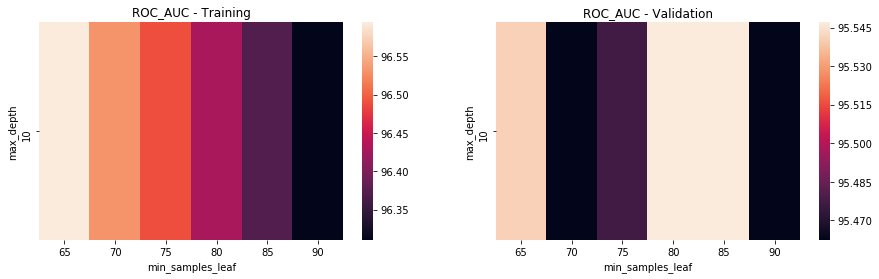

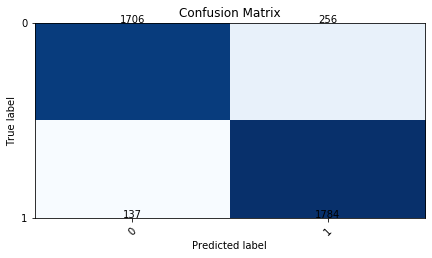

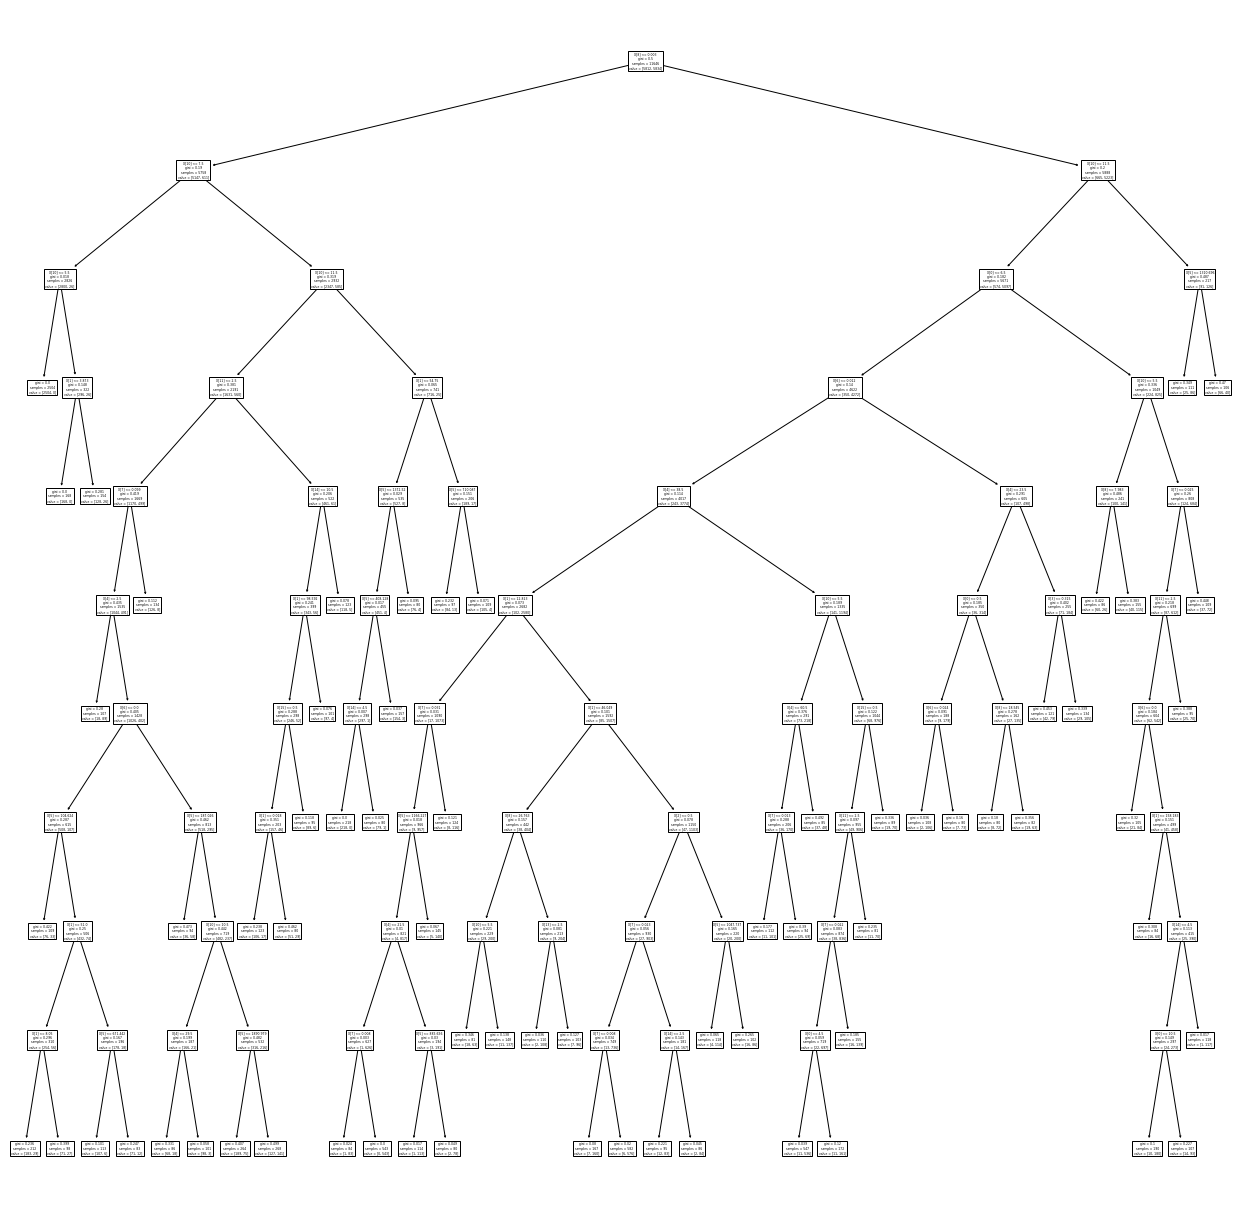

In [82]:
dtree = Classification('Decision Tree', X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[10],                 # The maximum depth of the tree
              'min_samples_leaf':[65, 70, 75, 80, 85, 90]}  # The minimum number of samples required to be at a leaf node

dtree.get_scores(param_grid,skf)
dtree.opt_plots()
dtree.show_conf_matrix()
dtree.plot_decision_tree()

## K Nearest Naighbors

In [56]:
min_k=1
max_k=25
best_k = 0
best_score = 0.0
for k in range(min_k, max_k+1, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_v, y_train_v)
    preds = knn.predict(X_test)
    f1 = f1_score(y_test, preds)
    if f1 > best_score:
        best_k = k
        best_score = f1
best_k

1

[[1585  377]
 [  97 1824]]


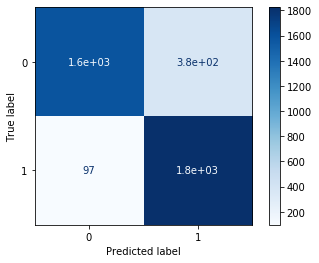

In [78]:
knn = KNeighborsClassifier(n_neighbors = 1)

knnfit = knn.fit(X_train_v, y_train_v)
y_pred = knn.predict(X_train_v)
# confmatrix = plot_confusion_matrix(knnfit, X_val, y_val)
disp = plot_confusion_matrix(knnfit, X_val, y_val,
                             cmap=plt.cm.Blues)

print(disp.confusion_matrix)

plt.show()

## Random Forest

,Model Name,Train AUC,Validation AUC
0,Random Forest,0.999854,0.970076


The best hyperparameters are:  {'max_depth': 25, 'min_samples_leaf': 1} 



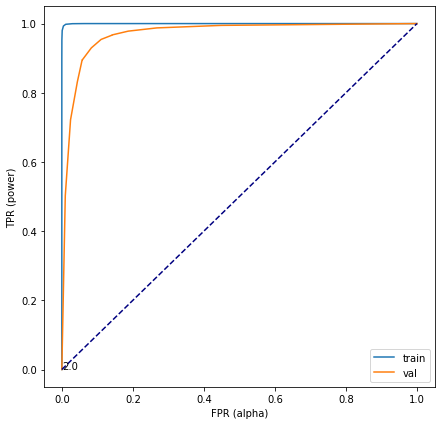

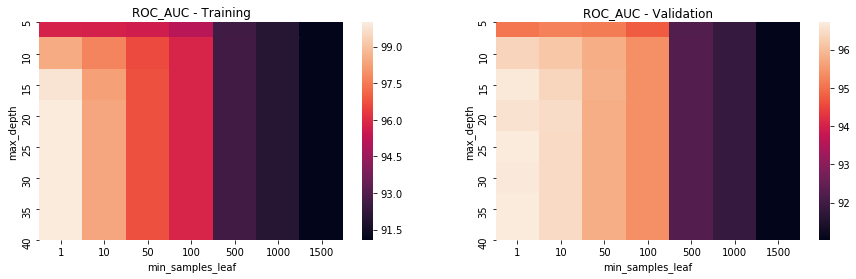

In [58]:
ran_forest = Classification('Random Forest',X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[5,10,15,20,25,30,35,40],           # The maximum depth of the tree
              'min_samples_leaf':[1,10,50,100,500,1000,1500]} # The minimum number of samples required to be at a leaf node

ran_forest.get_scores(param_grid,skf)
ran_forest.opt_plots()

,Model Name,Train AUC,Validation AUC
0,Random Forest,0.999854,0.970076


The best hyperparameters are:  {'max_depth': 25, 'min_samples_leaf': 1} 



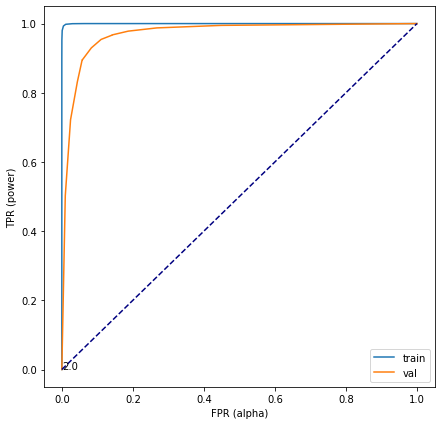

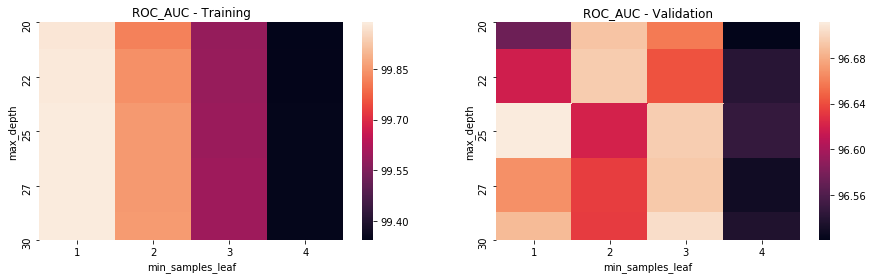

In [83]:
ran_forest = Classification('Random Forest',X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[20, 22, 25, 27, 30],           # The maximum depth of the tree
              'min_samples_leaf':[1, 2, 3, 4]} # The minimum number of samples required to be at a leaf node

ran_forest.get_scores(param_grid,skf)
ran_forest.opt_plots()

## Stacking with XGBoost

In [61]:
models = [
    RandomForestClassifier(n_estimators = 10, max_depth = 13, 
                           min_samples_leaf = 20,
                           n_jobs = -1, random_state=42),
          knn,
          DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 150, random_state = 42), 
          LogisticRegression(penalty = 'l2', C = 0.8, fit_intercept = True, solver = 'liblinear')
         ]

In [62]:
S_train, S_test = stacking(models,                   
                           X_train_v, y_train_v, X_val,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=roc_auc_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=42,
                          
                          verbose = 2)

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [RandomForestClassifier]
    fold  0:  [0.90418420]
    fold  1:  [0.90828104]
    fold  2:  [0.90275453]
    fold  3:  [0.88832528]
    ----
    MEAN:     [0.90088626] + [0.00753040]
    FULL:     [0.90088647]

model  1:     [KNeighborsClassifier]
    fold  0:  [0.85254421]
    fold  1:  [0.85044980]
    fold  2:  [0.82880153]
    fold  3:  [0.83841789]
    ----
    MEAN:     [0.84255336] + [0.00959669]
    FULL:     [0.84255498]

model  2:     [DecisionTreeClassifier]
    fold  0:  [0.89285669]
    fold  1:  [0.89276187]
    fold  2:  [0.88730709]
    fold  3:  [0.88216660]
    ----
    MEAN:     [0.88877306] + [0.00442665]
    FULL:     [0.88877521]

model  3:     [LogisticRegression]
    fold  0:  [0.83838854]
    fold  1:  [0.84759900]
    fold  2:  [0.83143810]
    fold  3:  [0.83316458]
    ----
    MEAN:     [0.83764755] + [0.00628957]
   

In [63]:
model = XGBClassifier(random_state=42, n_jobs=-1, learning_rate=0.5, 
                      n_estimators=100, max_depth=3)
    
model = model.fit(S_train, y_train_v)
y_pred = model.predict(S_test)

print('Final prediction score: [%.8f]' % roc_auc_score(y_val, y_pred))

Final prediction score: [0.90901278]


## Threshold Selection

In [100]:
final = RandomForestClassifier(n_estimators = 10, max_depth = 25, 
                           min_samples_leaf = 1,
                           n_jobs = -1, random_state=42)
model = final.fit(X_train_v, y_train_v)

In [101]:
val_prob = model.predict_proba(X_val)[:,1]

In [102]:
fpr, tpr, thresh = roc_curve(y_val, val_prob)

In [103]:
df_t = pd.DataFrame()
df_t['fpr'] = fpr
df_t['tpr'] = tpr
df_t['thresh'] = thresh

In [104]:
fp = 1
tn = 0

fn = 10
tp = -5
prevalence = df['Revenue'].sum()/df.shape[0]

In [105]:
m = ((1 - prevalence) / prevalence) * ((fp-tn) / (fn-tp))

In [106]:
for i in df_t.index:
    df_t.loc[i, 'fm'] = df_t.loc[i, 'tpr'] - (m * df_t.loc[i, 'fpr'])

In [119]:
df_t.sort_values(by='fm', ascending=False, inplace=True)
df_t.head()

,fpr,tpr,thresh,fm
13,0.141692,0.967205,0.397368,0.915515
12,0.141692,0.966684,0.400000,0.914995
11,0.110601,0.954191,0.500000,0.913843
14,0.187054,0.978136,0.300000,0.909899
10,0.083078,0.929724,0.600000,0.899417


In [120]:
threshold = 0.397368

In [121]:
model.fit(X_test, y_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [122]:
predicted_proba = model.predict_proba(X_test)
predicted = (predicted_proba[:,1] >= threshold).astype('int')

In [124]:
unique, counts = np.unique(predicted, return_counts=True)
dict(zip(unique, counts))

{0: 2496, 1: 2681}

In [126]:
def conf_matrix(y_true, y_pred):
        
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
                
        return cm

In [127]:
def plot_conf_matrix(y_true, y_predicted):
        
        cnf_matrix = confusion_matrix(y_true, predicted)
        
        plt.figure(figsize=(8,18))
        plt.imshow(cnf_matrix, cmap=plt.cm.Greens)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(1,2,1)
        plt.xticks(tick_marks, [1,0], rotation=45)
        plt.yticks(tick_marks, [1,0])

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

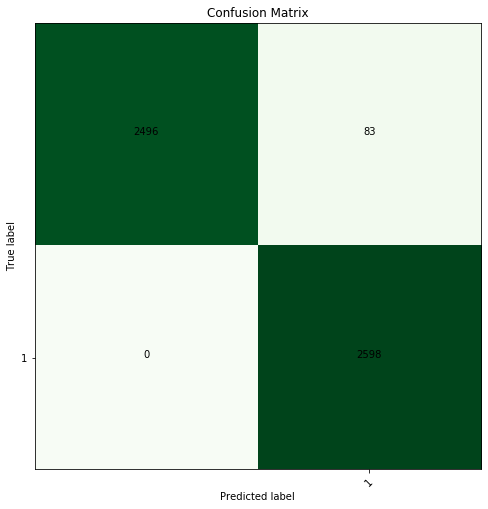

In [128]:
plot_conf_matrix(y_test, predicted)